# FuzzyART com a base de dados Iris

FuzzyART é o modelo ART mais usado.

## Importando bibliotecas e baixando base de dados

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from artlib import FuzzyART
from sklearn.metrics import accuracy_score
import pandas as pd

X, y = datasets.load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


## Teste com vários hiperparâmetros

<font color="#6fa849ff">**Entendendo os parâmetros**</font> 

- Beta ($\beta$): Fica no intervalo (0,1] e é o parâmetro de aprendizado. Quando $\beta = 1$, dizemos que o modelo está no modo de aprendizado rápido.
    - Controla a atualização dos pesos.

- Rho ($\rho$): Parâmetro de vigilância. Se $M_j(x) < \rho$, a categoria é rejeitada. 
    - Obs.: $M_j$ é a função "match", $M_j(x)$ mede o quanto uma entrada x é coberta pela categoria j.
    - Um $\rho$ alto causa mais categorias, mais especificidade e menor generalização.
    - É o parâmetro que mais afeta a ocorrência de under/overfitting.

- Alpha ($\alpha$): Parâmetro de escolha, controla a divisão por zero.

<font color="#6fa849ff">**Definição dos limites para os valores dos dados**</font> 

Para isso, juntaremos todos os dados (treino e teste) e deixaremos o modelo calcular os limites de forma automática:

```python
lower_bound, upper_bound = model.find_data_bounds(X)
model.set_data_bounds(lower_bound, upper_bound)
```

<font color="red">Dúvida:</font>
O README da biblioteca ARTlib diz: "Se o primeiro lote ("batch") dos seus dados de treinamento for representativo de todo o espaço de dados você não precisa fazer nada e a artlib vai identificar os limites dos dadso automaticamente." 

Nesse caso, como todos os dados que são utilizados já estão em X, acredito que essa normalização não é necessária.


In [2]:
alphas = [1e-6, 1e-3, 1e-2, 1e-1, 1.0, 10.0] 
rhos   = [0.1, 0.3, 0.5, 0.7, 0.9]
betas  = [1.0, 0.5, 0.1]

results = []

for alpha in alphas:
    for rho in rhos:
        for beta in betas:

            model = FuzzyART(rho=rho, alpha=alpha, beta=beta)
            
            lower_bound, upper_bound = model.find_data_bounds(X)
            model.set_data_bounds(lower_bound, upper_bound)

            # Preparar os dados (normalizados internamente pelo modelo)
            train_X_prep = model.prepare_data(X_train)
            test_X_prep  = model.prepare_data(X_test)

            # Treinar
            model.fit(train_X_prep, y_train)

            # Prever
            predictions = model.predict(test_X_prep)

            # Calcular accuracy
            acc = accuracy_score(y_test, predictions)

            results.append({
                'alpha': alpha,
                'rho': rho,
                'beta': beta,
                'accuracy': acc
            })

            #print(f"alpha={alpha:.1e}, rho={rho}, beta={beta} → acc={acc:.3f}")

df_results = pd.DataFrame(results)
best_results = df_results.sort_values(by='accuracy', ascending=False).head(10)


In [3]:
print("10 melhores combinações:")
print(best_results)

10 melhores combinações:
        alpha  rho  beta  accuracy
80  10.000000  0.3   0.1  0.650000
45   0.100000  0.1   1.0  0.633333
63   1.000000  0.3   1.0  0.433333
75  10.000000  0.1   1.0  0.400000
60   1.000000  0.1   1.0  0.383333
6    0.000001  0.5   1.0  0.383333
36   0.010000  0.5   1.0  0.383333
21   0.001000  0.5   1.0  0.383333
51   0.100000  0.5   1.0  0.366667
65   1.000000  0.3   0.1  0.350000


## Gráficos dos melhores resultados

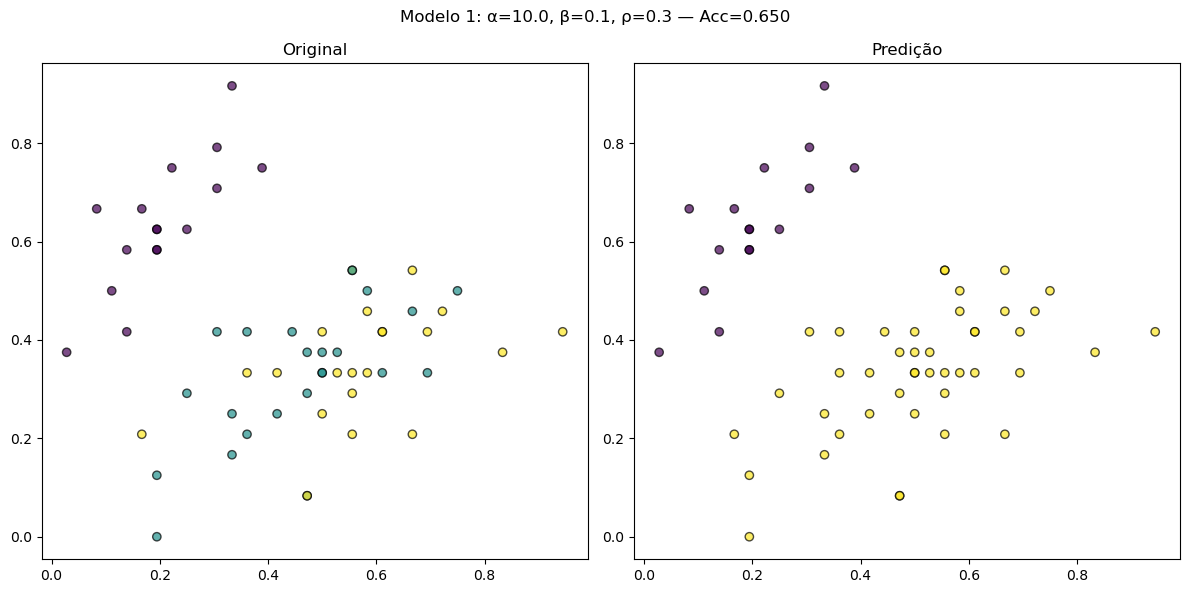

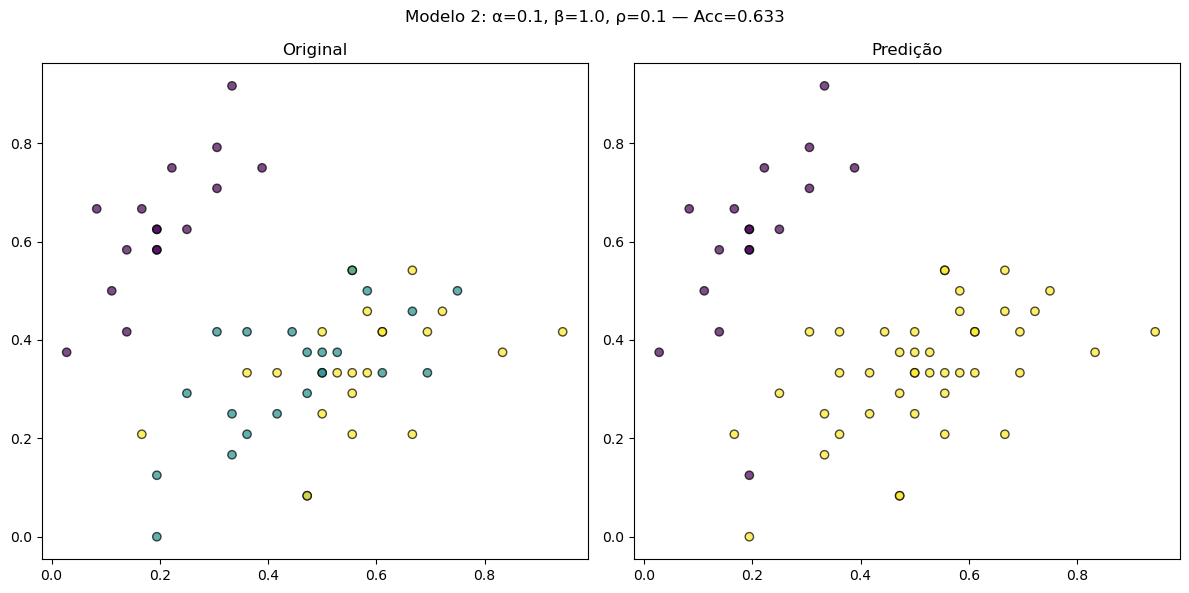

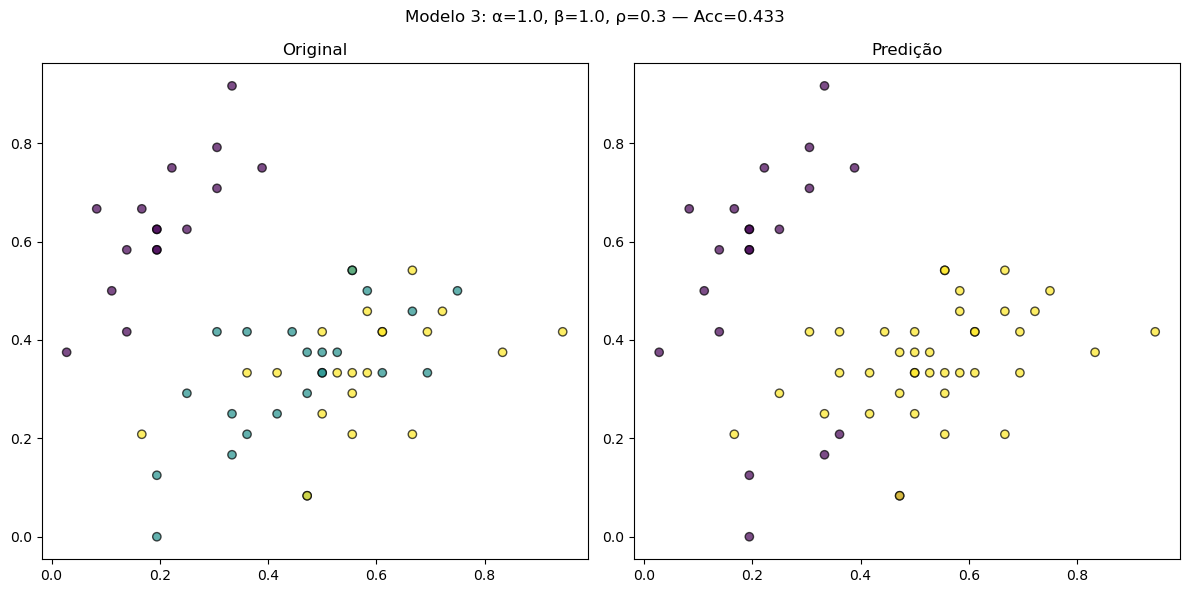

In [4]:
for i in range(0, 3):
    values = best_results.iloc[i]
    model = FuzzyART(rho=values['rho'], alpha=values['alpha'], beta=values['beta'])

    lower_bound, upper_bound = model.find_data_bounds(X)
    model.set_data_bounds(lower_bound, upper_bound)

    # Preparar os dados (normalizados internamente pelo modelo)
    train_X_prep = model.prepare_data(X_train)
    test_X_prep  = model.prepare_data(X_test)

    # Treinar
    model.fit(train_X_prep, y_train)

    # Prever
    predictions = model.predict(test_X_prep)

    f, subplots = plt.subplots(1, 2, figsize=(12, 6))

    subplots[0].scatter(
        test_X_prep[:, 0],
        test_X_prep[:, 1],  # coordenadas x e y
        c=y_test,  # cor de acordo com a classe (0 ou 1)
        edgecolors="k",  # contorno preto em cada ponto
        alpha=0.7,
    )
    subplots[0].set_title("Original")
    
    subplots[1].scatter(
        test_X_prep[:, 0],
        test_X_prep[:, 1],  # coordenadas x e y
        c=predictions,  # cor de acordo com a classe (0 ou 1)
        edgecolors="k",  # contorno preto em cada ponto
        alpha=0.7,
    )
    subplots[1].set_title("Predição")

    f.suptitle(f"Modelo {i+1}: α={values['alpha']}, β={values['beta']}, ρ={values['rho']} — Acc={values['accuracy']:.3f}",
                 fontsize=12)
    plt.tight_layout()
    plt.show()